In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import os
import string
from scipy.interpolate import lagrange
from scipy import interpolate
from scipy.optimize import curve_fit
import pandas as pd
from astropy.stats import poisson_conf_interval
import scipy
import warnings
import glob
from astropy.coordinates import SkyCoord
import astropy.units as u
warnings.filterwarnings("ignore")

In [32]:
# path='/data/galaxy/xmm/GalDisc/'
pathmy='/Users/baotong/data_GalDisc/data/xmmdr14s/'
obsused=np.loadtxt(pathmy+'obs_dr14s.txt',dtype='str')
allsrc=fits.open(pathmy+'GalDisc_4xmmdr14s.fits')[1].data
cleansrc=fits.open(pathmy+'GalDisc_4xmmdr14s_new_cleaned.fits')[1].data
print(len(allsrc))
print(len(cleansrc))


122740
58333


In [33]:
N_CONTRIB=np.array(cleansrc['N_CONTRIB'])

In [35]:
real_sources_indices = np.where(N_CONTRIB>0)[0]
obs_info_indices = []
# 遍历每个真实源的行号，找其对应的观测信息
for i, start_index in enumerate(real_sources_indices):
    if i < len(real_sources_indices) - 1:
        # 真实源之间的观测行号
        end_index = real_sources_indices[i + 1]
        obs_indices = list(range(start_index + 1, end_index))
    else:
        # 最后一个真实源之后的观测行号
        obs_indices = list(range(start_index + 1, len(cleansrc)))
    obs_info_indices.append(obs_indices)
    
print("真实源的行号:", real_sources_indices)
print("观测信息的行号:", obs_info_indices)

真实源的行号: [    0     7    14 ... 58324 58327 58330]
观测信息的行号: [[1, 2, 3, 4, 5, 6], [8, 9, 10, 11, 12, 13], [15, 16, 17, 18, 19, 20, 21], [23, 24, 25, 26, 27, 28], [30, 31, 32, 33, 34, 35, 36, 37], [39, 40, 41, 42, 43], [45, 46, 47, 48, 49, 50], [52, 53, 54], [56, 57], [59, 60, 61, 62, 63, 64, 65], [67, 68, 69, 70, 71], [73, 74], [76, 77, 78], [80, 81, 82, 83, 84, 85, 86], [88, 89, 90, 91, 92], [94, 95, 96, 97, 98, 99], [101, 102, 103], [105, 106, 107], [109, 110, 111, 112, 113, 114], [116, 117, 118, 119, 120, 121, 122], [124, 125, 126], [128, 129, 130], [132, 133], [135, 136, 137, 138], [140, 141], [143, 144, 145, 146, 147], [149, 150, 151, 152, 153, 154], [156, 157, 158, 159, 160], [162, 163, 164, 165, 166, 167], [169, 170, 171], [173, 174, 175, 176, 177, 178], [180, 181, 182, 183, 184, 185], [187, 188, 189], [191, 192, 193, 194, 195], [197, 198, 199, 200, 201, 202, 203, 204], [206, 207, 208], [210, 211, 212], [214, 215, 216, 217, 218], [220, 221, 222], [224, 225, 226, 227, 228, 229], [2

In [36]:
real_sources=cleansrc[real_sources_indices]
print(len(real_sources))
print(len(np.where(N_CONTRIB==1)[0]))
print(len(np.where(N_CONTRIB>1)[0]))

15655
6122
9533


[]

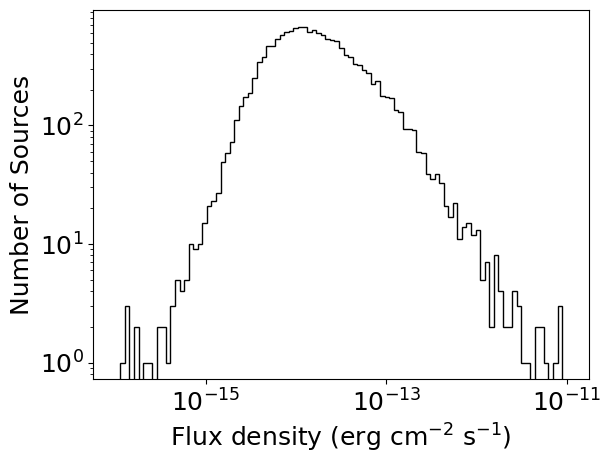

In [147]:
flux=real_sources['EP_FLUX']
fluxerr=real_sources['EP_FLUX_err']
bins_flux=np.logspace(-16,-11,100)
plt.hist(flux,bins_flux,histtype='step',color='k')
plt.xlabel(r'$\rm Flux~density~(erg~cm^{-2}~s^{-1})$',fontsize=18)
plt.ylabel('Number of Sources',fontsize=18)
plt.tick_params(labelsize=18)
plt.loglog()

[]

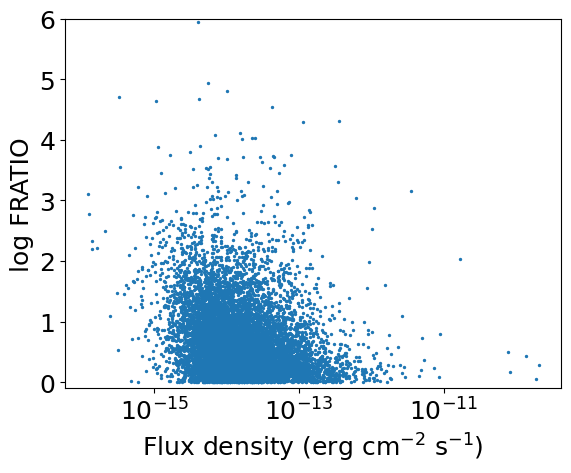

In [152]:
VI=real_sources['FRATIO']
VI_err=real_sources['FRATIO_ERR']
# bins_flux=np.logspace(-16,-11,1000)
plt.ylim(-0.1,6)
plt.scatter(flux,np.log10(VI),marker='o',s=2)
plt.xlabel(r'$\rm Flux~density~(erg~cm^{-2}~s^{-1})$',fontsize=18)
plt.ylabel('log FRATIO',fontsize=18)
plt.tick_params(labelsize=18)
plt.semilogx()

[]

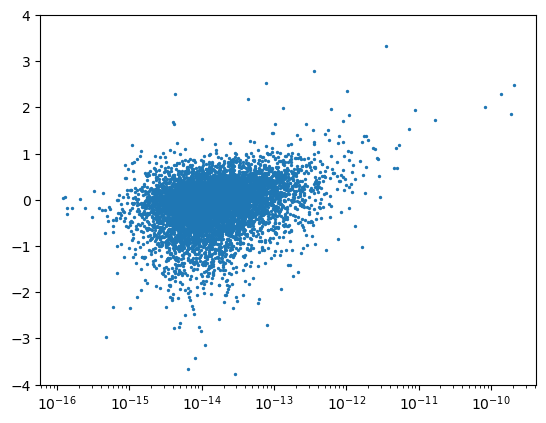

In [153]:
FLUXVAR=real_sources['FLUXVAR']
# FLUXVAR_ERR=real_sources['FLUXVAR_ERR']
# bins_flux=np.logspace(-16,-11,1000)
plt.scatter(flux,np.log10(FLUXVAR),marker='o',s=2)
plt.ylim(-4,4)
plt.semilogx()

46 46


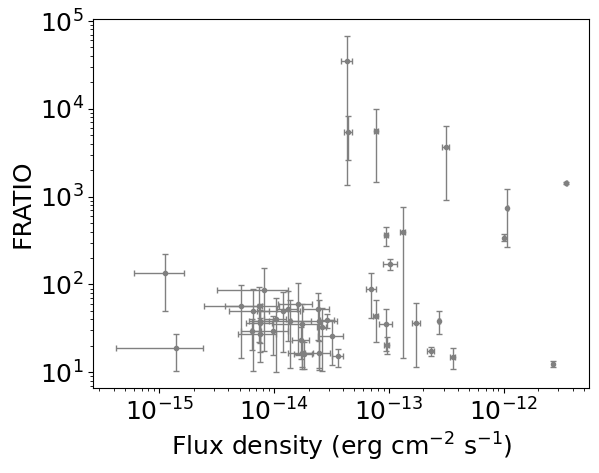

In [154]:
goodindex1=np.where((flux>fluxerr)&(VI>VI_err)&((VI-VI_err)>10))[0]
goodindex=np.where((VI-VI_err)>10)[0]
print(len(goodindex1),len(goodindex))
plt.errorbar(x=flux[goodindex],xerr=fluxerr[goodindex],y=VI[goodindex],yerr=VI_err[goodindex],fmt='.', 
                 capsize=2,elinewidth=1, ecolor='gray',
                 color='gray',linewidth=1)
plt.xlabel(r'$\rm Flux~density~(erg~cm^{-2}~s^{-1})$',fontsize=18)
plt.ylabel('FRATIO',fontsize=18)
plt.loglog()
plt.tick_params(labelsize=18)
# plt.ylim(10,1e5)
plt.show()

In [155]:
allphysrc=allsrc[np.where(allsrc['N_CONTRIB']>0)]
print(len(allphysrc))
coordall=SkyCoord(ra=allphysrc['RA']*u.degree,dec=allphysrc['DEC']*u.degree)

26542


In [61]:
def closest_source(ra,dec):
    coord1=SkyCoord(ra=ra*u.degree,dec=dec*u.degree)
    sep=coord1.separation(coordall)
    closet_index=np.argmin(sep)
    return closet_index,sep[closet_index].arcsec,allphysrc[closet_index]

In [73]:
a,b,c=closest_source(ra=267.3237626,dec=-28.55814656)
flag=c['STACK_FLAG'];detml=c['EP_DET_ML'];extent=c['EXTENT_ML']
print(a,b,flag,detml,extent)

17058 6.127106909061847e-05 1 6611.0146 -2.2700195


In [ ]:
print(len(np.where(allphysrc['EXTENT']==0)[0]))
print(len(np.where((allphysrc['EXTENT']<6)&(allphysrc['EXTENT']>0))[0]))
print(len(np.where((allphysrc['EXTENT_ML']==0))[0]))
print(len(np.where((allphysrc['EXTENT']<=0)&(allphysrc['STACK_FLAG']<=1)&(allphysrc['EP_DET_ML']>6))[0]))

24289
0
84
15655


2669


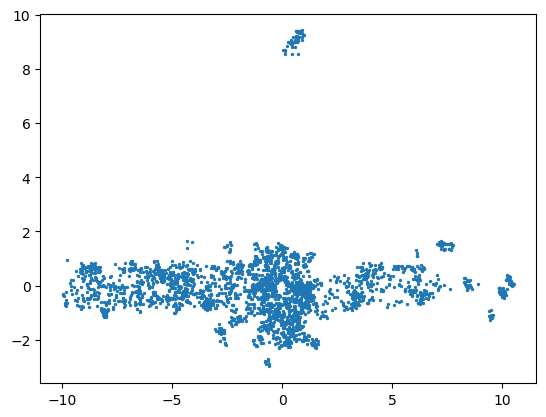

In [165]:
strangesrc=real_sources[np.where((real_sources['EXTENT']==0)&(real_sources['EXTENT_ML']>0))[0]]
print(len(strangesrc))
l_coords=strangesrc['LII']
l_coords_shifted = np.mod(l_coords - 180, 360) - 180 
plt.scatter(l_coords_shifted,strangesrc['BII'],marker='o',s=2)
plt.xlim()
plt.show()

In [168]:
new_extentsrc=fits.open(pathmy+'GalDisc_4xmmdr14s_newextent_cleaned.fits')[1].data
print(len(new_extentsrc[np.where(new_extentsrc['N_CONTRIB']>0)]))


2669


In [31]:
ncontrib=cleansrc['N_CONTRIB']
ephr1=cleansrc['EP_HR2']
print(ncontrib)
print(np.sum(np.isnan(ephr1)))
print(len(np.where(ncontrib==1)[0]))
indices = np.where((ncontrib > 0) & np.isnan(ephr1))[0]

# 数量和序列号
nan_count = len(indices)
print(f"相同位置为 NaN 的元素数目: {nan_count}")
print(f"这些元素的序列号: {indices}")
# 条件筛选：n_contrib > 0 且 ephr1 不为 NaN
valid_indices = np.where((ncontrib > 1) & ~np.isnan(ephr1))[0]

# 计算数量
count = len(valid_indices)
print(f"当 n_contrib > 0 时，ephr1 不为 NaN 的数量: {count}")

# 条件筛选：ephr1 等于 NaN 且 ncontrib 等于 0
nan_zero_indices = np.where(np.isnan(ephr1) & (ncontrib <0))[0]

# 计算数量
count_nan_zero = len(nan_zero_indices)
print(f"当 ephr1 等于 NaN 且 ncontrib < 0 的数量: {count_nan_zero}")


[          6 -2147483648 -2147483648 ...           2 -2147483648
 -2147483648]
16404
6122
相同位置为 NaN 的元素数目: 13992
这些元素的序列号: [    0     7    14 ... 58059 58075 58091]
当 n_contrib > 0 时，ephr1 不为 NaN 的数量: 1117
当 ephr1 等于 NaN 且 ncontrib < 0 的数量: 2412
